In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master('local[*]').appName('joins').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/04 11:31:45 WARN Utils: Your hostname, deepak-ubuntu, resolves to a loopback address: 127.0.1.1; using 192.168.31.105 instead (on interface wlp1s0)
25/10/04 11:31:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/04 11:31:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

# 🧠 Spark Joins Summary

## 1. Inner Join
- **Definition:** Returns rows with matching keys in both DataFrames.
- **Syntax:**
  df1.join(df2, df1.id == df2.id, "inner")
- **Use Case:** Default join; filters out non-matching records.

## 2. Left Outer Join (Left Join)
- **Definition:** Returns all rows from the left DataFrame, and matching rows from the right.
- **Syntax:**
  df1.join(df2, df1.id == df2.id, "left")
- **Use Case:** Keep all records from left, even if no match on right.

## 3. Right Outer Join (Right Join)
- **Definition:** Returns all rows from the right DataFrame, and matching rows from the left.
- **Syntax:**
  df1.join(df2, df1.id == df2.id, "right")
- **Use Case:** Keep all records from right, even if no match on left.

## 4. Full Outer Join
- **Definition:** Returns all rows from both DataFrames, with nulls where no match.
- **Syntax:**
  df1.join(df2, df1.id == df2.id, "outer")
- **Use Case:** Combine both datasets, preserving all information.

## 5. Left Semi Join
- **Definition:** Returns only rows from the left DataFrame that have a match in the right.
- **Syntax:**
  df1.join(df2, df1.id == df2.id, "left_semi")
- **Use Case:** Like a SQL `EXISTS`; used for filtering.

## 6. Left Anti Join
- **Definition:** Returns rows from the left DataFrame **that do not** have a match in the right.
- **Syntax:**
  df1.join(df2, df1.id == df2.id, "left_anti")
- **Use Case:** Like a SQL `NOT EXISTS`; used for excluding.

## 7. Cross Join (Cartesian Join)
- **Definition:** Returns all combinations of rows from both DataFrames.
- **Syntax:**
  df1.crossJoin(df2)
- **Use Case:** Used rarely; can explode data size exponentially.

## 8. Natural Join (Spark SQL only)
- **Definition:** Joins automatically on all columns with the same name.
- **Syntax:**
  spark.sql("SELECT * FROM df1 NATURAL JOIN df2")
- **Use Case:** Useful in SQL-style syntax, not via DataFrame API.

---

# ⚡ Notes
- Default join type = **"inner"**
- Joins are **lazy** — executed only on an action (e.g. `.show()`, `.count()`).
- For performance: prefer **broadcast joins** when one DataFrame is small.
  ```python
  from pyspark.sql.functions import broadcast
  df1.join(broadcast(df2), "id", "inner")


In [4]:
from pyspark.sql import functions as fn, types as ty, Row

In [5]:
person = spark.createDataFrame([
Row(0, "Bill Chambers", 0, [100]),
Row(1, "Matei Zaharia", 1, [500, 250, 100]),
Row(2, "Michael Armbrust", 1, [250, 100])])\
.toDF("id", "name", "graduate_program", "spark_status")

In [6]:
person.show()

+---+----------------+----------------+---------------+
| id|            name|graduate_program|   spark_status|
+---+----------------+----------------+---------------+
|  0|   Bill Chambers|               0|          [100]|
|  1|   Matei Zaharia|               1|[500, 250, 100]|
|  2|Michael Armbrust|               1|     [250, 100]|
+---+----------------+----------------+---------------+



In [7]:
graduateProgram = spark.createDataFrame([
(0, "Masters", "School of Information", "UC Berkeley"),
(2, "Masters", "EECS", "UC Berkeley"),
(1, "Ph.D.", "EECS", "UC Berkeley")])\
.toDF("id", "degree", "department", "school")

In [8]:
sparkStatus = spark.createDataFrame([
(500, "Vice President"),
(250, "PMC Member"),
(100, "Contributor")])\
.toDF("id", "status")

In [9]:
person.createOrReplaceTempView("person")
graduateProgram.createOrReplaceTempView("graduateProgram")
sparkStatus.createOrReplaceTempView("sparkStatus")

In [10]:
spark.sql("""
select * from person
""").show()

+---+----------------+----------------+---------------+
| id|            name|graduate_program|   spark_status|
+---+----------------+----------------+---------------+
|  0|   Bill Chambers|               0|          [100]|
|  1|   Matei Zaharia|               1|[500, 250, 100]|
|  2|Michael Armbrust|               1|     [250, 100]|
+---+----------------+----------------+---------------+



In [11]:
spark.sql("""
select * from graduateprogram
""").show()

+---+-------+--------------------+-----------+
| id| degree|          department|     school|
+---+-------+--------------------+-----------+
|  0|Masters|School of Informa...|UC Berkeley|
|  2|Masters|                EECS|UC Berkeley|
|  1|  Ph.D.|                EECS|UC Berkeley|
+---+-------+--------------------+-----------+



In [12]:
spark.sql("""
select * from sparkstatus
""").show()

+---+--------------+
| id|        status|
+---+--------------+
|500|Vice President|
|250|    PMC Member|
|100|   Contributor|
+---+--------------+



In [13]:
joinExpression = person['graduate_program'] == graduateProgram['id']

In [14]:
person.cache()

DataFrame[id: bigint, name: string, graduate_program: bigint, spark_status: array<bigint>]

In [15]:
graduateProgram.cache()

DataFrame[id: bigint, degree: string, department: string, school: string]

In [16]:
sparkStatus.cache()

DataFrame[id: bigint, status: string]

In [17]:
#inner join by default
person.join(graduateProgram, joinExpression).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [18]:
jointype = 'inner'
person.join(graduateProgram, joinExpression, jointype).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [19]:
jointype = 'outer'
person.join(graduateProgram, joinExpression, jointype).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [20]:
jointype = 'left_outer'
person.join(graduateProgram, joinExpression, jointype).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [21]:
jointype = 'right_outer'
person.join(graduateProgram, joinExpression, jointype).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   1|   Matei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [22]:
#left_semi join
jointype = 'left_semi'
graduateProgram.join(person, joinExpression, jointype).show()

+---+-------+--------------------+-----------+
| id| degree|          department|     school|
+---+-------+--------------------+-----------+
|  0|Masters|School of Informa...|UC Berkeley|
|  1|  Ph.D.|                EECS|UC Berkeley|
+---+-------+--------------------+-----------+



In [23]:
jointype = 'left_anti'
graduateProgram.join(person, joinExpression, jointype).show()

+---+-------+----------+-----------+
| id| degree|department|     school|
+---+-------+----------+-----------+
|  2|Masters|      EECS|UC Berkeley|
+---+-------+----------+-----------+



In [25]:
jointype = 'cross'
graduateProgram.join(person, joinExpression, jointype).show()

+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
| id| degree|          department|     school| id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|  0|   Bill Chambers|               0|          [100]|
|  1|  Ph.D.|                EECS|UC Berkeley|  1|   Matei Zaharia|               1|[500, 250, 100]|
|  1|  Ph.D.|                EECS|UC Berkeley|  2|Michael Armbrust|               1|     [250, 100]|
+---+-------+--------------------+-----------+---+----------------+----------------+---------------+



In [29]:
graduateProgram.join(person, how='cross').orderBy(graduateProgram.id).show(truncate=False)

+---+-------+---------------------+-----------+---+----------------+----------------+---------------+
|id |degree |department           |school     |id |name            |graduate_program|spark_status   |
+---+-------+---------------------+-----------+---+----------------+----------------+---------------+
|0  |Masters|School of Information|UC Berkeley|2  |Michael Armbrust|1               |[250, 100]     |
|0  |Masters|School of Information|UC Berkeley|1  |Matei Zaharia   |1               |[500, 250, 100]|
|0  |Masters|School of Information|UC Berkeley|0  |Bill Chambers   |0               |[100]          |
|1  |Ph.D.  |EECS                 |UC Berkeley|1  |Matei Zaharia   |1               |[500, 250, 100]|
|1  |Ph.D.  |EECS                 |UC Berkeley|2  |Michael Armbrust|1               |[250, 100]     |
|1  |Ph.D.  |EECS                 |UC Berkeley|0  |Bill Chambers   |0               |[100]          |
|2  |Masters|EECS                 |UC Berkeley|1  |Matei Zaharia   |1             

In [30]:
joinCondition = graduateProgram['ID'] != person['ID']
graduateProgram.join(person, joinCondition,how='cross').orderBy(graduateProgram.id).show(truncate=False)

+---+-------+---------------------+-----------+---+----------------+----------------+---------------+
|id |degree |department           |school     |id |name            |graduate_program|spark_status   |
+---+-------+---------------------+-----------+---+----------------+----------------+---------------+
|0  |Masters|School of Information|UC Berkeley|2  |Michael Armbrust|1               |[250, 100]     |
|0  |Masters|School of Information|UC Berkeley|1  |Matei Zaharia   |1               |[500, 250, 100]|
|1  |Ph.D.  |EECS                 |UC Berkeley|0  |Bill Chambers   |0               |[100]          |
|1  |Ph.D.  |EECS                 |UC Berkeley|2  |Michael Armbrust|1               |[250, 100]     |
|2  |Masters|EECS                 |UC Berkeley|1  |Matei Zaharia   |1               |[500, 250, 100]|
|2  |Masters|EECS                 |UC Berkeley|0  |Bill Chambers   |0               |[100]          |
+---+-------+---------------------+-----------+---+----------------+--------------

In [28]:
%%sparksql
select * from graduateProgram cross join person

id,degree,department,school,id,name,graduate_program,spark_status
0,Masters,School of Information,UC Berkeley,0,Bill Chambers,0,[100]
2,Masters,EECS,UC Berkeley,0,Bill Chambers,0,[100]
1,Ph.D.,EECS,UC Berkeley,0,Bill Chambers,0,[100]
0,Masters,School of Information,UC Berkeley,1,Matei Zaharia,1,"[500, 250, 100]"
2,Masters,EECS,UC Berkeley,1,Matei Zaharia,1,"[500, 250, 100]"
1,Ph.D.,EECS,UC Berkeley,1,Matei Zaharia,1,"[500, 250, 100]"
0,Masters,School of Information,UC Berkeley,2,Michael Armbrust,1,"[250, 100]"
2,Masters,EECS,UC Berkeley,2,Michael Armbrust,1,"[250, 100]"
1,Ph.D.,EECS,UC Berkeley,2,Michael Armbrust,1,"[250, 100]"


In [29]:
%%sparksql
select * from sparkStatus

id,status
500,Vice President
250,PMC Member
100,Contributor


In [30]:
%%sparksql
select * from (select * from person) p inner join sparkStatus st on array_contains(p.spark_status, st.id)

id,name,graduate_program,spark_status,id,status
0,Bill Chambers,0,[100],100,Contributor
1,Matei Zaharia,1,"[500, 250, 100]",500,Vice President
1,Matei Zaharia,1,"[500, 250, 100]",250,PMC Member
1,Matei Zaharia,1,"[500, 250, 100]",100,Contributor
2,Michael Armbrust,1,"[250, 100]",250,PMC Member
2,Michael Armbrust,1,"[250, 100]",100,Contributor


In [37]:
joinExpression

Column<'(graduate_program = id)'>

In [39]:
#cross
jointype = 'cross'
graduateProgram.join(person, joinExpression, jointype).show()

+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
| id| degree|          department|     school| id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+---+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|  0|   Bill Chambers|               0|          [100]|
|  1|  Ph.D.|                EECS|UC Berkeley|  1|   Matei Zaharia|               1|[500, 250, 100]|
|  1|  Ph.D.|                EECS|UC Berkeley|  2|Michael Armbrust|               1|     [250, 100]|
+---+-------+--------------------+-----------+---+----------------+----------------+---------------+



In [44]:
#cross
jointype = 'cross'
help(graduateProgram.join)
graduateProgram.join(other=person, how=jointype).show()

Help on method join in module pyspark.sql.dataframe:

join(other: 'DataFrame', on: Union[str, List[str], pyspark.sql.column.Column, List[pyspark.sql.column.Column], NoneType] = None, how: Optional[str] = None) -> 'DataFrame' method of pyspark.sql.dataframe.DataFrame instance
    Joins with another :class:`DataFrame`, using the given join expression.
    
    .. versionadded:: 1.3.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    Parameters
    ----------
    other : :class:`DataFrame`
        Right side of the join
    on : str, list or :class:`Column`, optional
        a string for the join column name, a list of column names,
        a join expression (Column), or a list of Columns.
        If `on` is a string or a list of strings indicating the name of the join column(s),
        the column(s) must exist on both sides, and this performs an equi-join.
    how : str, optional
        default ``inner``. Must be one of: ``inner``, ``cross``, ``outer``,
      

In [41]:

person.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- graduate_program: long (nullable = true)
 |-- spark_status: array (nullable = true)
 |    |-- element: long (containsNull = true)



In [31]:
#Joins on Complex Types
person.withColumnRenamed('id', 'personid').join(sparkStatus, fn.expr("array_contains(spark_status, id)")).show()

+--------+----------------+----------------+---------------+---+--------------+
|personid|            name|graduate_program|   spark_status| id|        status|
+--------+----------------+----------------+---------------+---+--------------+
|       1|   Matei Zaharia|               1|[500, 250, 100]|500|Vice President|
|       1|   Matei Zaharia|               1|[500, 250, 100]|250|    PMC Member|
|       2|Michael Armbrust|               1|     [250, 100]|250|    PMC Member|
|       0|   Bill Chambers|               0|          [100]|100|   Contributor|
|       1|   Matei Zaharia|               1|[500, 250, 100]|100|   Contributor|
|       2|Michael Armbrust|               1|     [250, 100]|100|   Contributor|
+--------+----------------+----------------+---------------+---+--------------+



<h2>Handling Duplicate Column Names While Joining</h2>
<ul>
    <li>
        <h4>Approach 1: Different join expression</h4>
            <p>
            When you have two keys that have the same name, probably the easiest fix is to change the join</br>
            expression from a Boolean expression to a string or sequence. This automatically removes one of</br>
            the columns for you during the join
            </p>
    </li>
    <li>
        <h4>Approach 2: Dropping the column after the join</h4>
    </li>
    <li>
        <h4>Approach 3: Renaming a column before the join</h4>
    </li>
</ul>

# ⚙️ How Spark Performs Joins

## Core Concepts
To understand how Spark executes joins, you must consider two core resources:
1. **Node-to-node communication strategy**
2. **Per-node computation strategy**

These determine how efficiently Spark can perform a join operation across a cluster.

---

## 🔄 Communication Strategies
Spark performs joins using **two main communication strategies**:

### 1. Shuffle Join
- Involves **all-to-all communication** between cluster nodes.
- Each node must exchange data with every other node based on join keys.
- This can cause **network congestion** if data is large or unevenly partitioned.

### 2. Broadcast Join
- Occurs when one table (the smaller one) is **broadcast** to all worker nodes.
- Each node performs the join **locally** without further inter-node communication.
- Only a **single broadcast** happens initially; after that, computation is CPU-bound.
- Ideal for **big table–small table** joins.

---

## 🧱 Big Table–to–Big Table (Shuffle Join)
- Used when **both tables are large**.
- Requires shuffling data across the cluster.
- **Every node communicates with every other node.**
- Very **network-intensive** and **expensive**.
- Example use case:
  > A company joining billions of IoT messages daily to detect day-over-day changes.

**Characteristics:**
- High network cost (all-to-all shuffle)
- Sensitive to data skew and partitioning
- Often the **default join type** when both datasets are large

---

## 🚀 Big Table–to–Small Table (Broadcast Join)
- Used when **one table is small enough** to fit into the memory of each worker node.
- Spark **replicates** (broadcasts) the small DataFrame to all nodes.
- Each node performs the join **independently**, reducing communication.
- **CPU becomes the main bottleneck** after broadcast.

**Characteristics:**
- One-time large communication (initial broadcast)
- No further inter-node communication
- Significantly faster for small-dimension joins
- Spark can automatically choose broadcast joins when:
  ```python
  spark.conf.get("spark.sql.autoBroadcastJoinThreshold")


### Big Table to Big Table

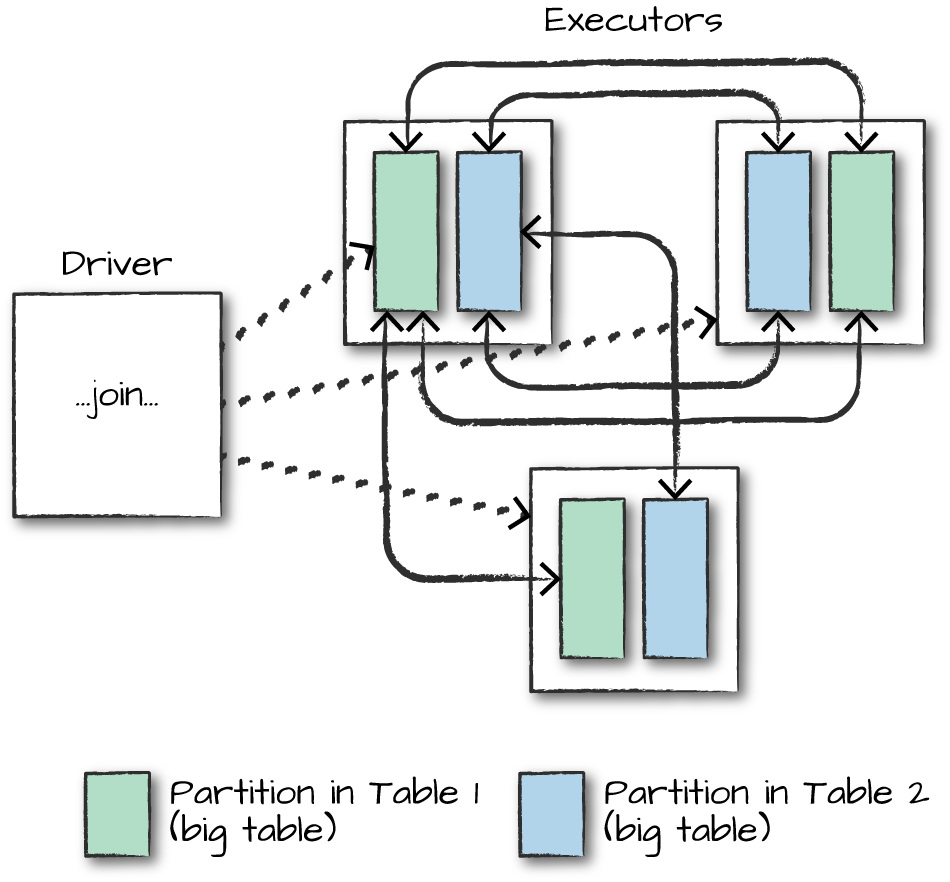

<h3>Big table–to–small table</h3>

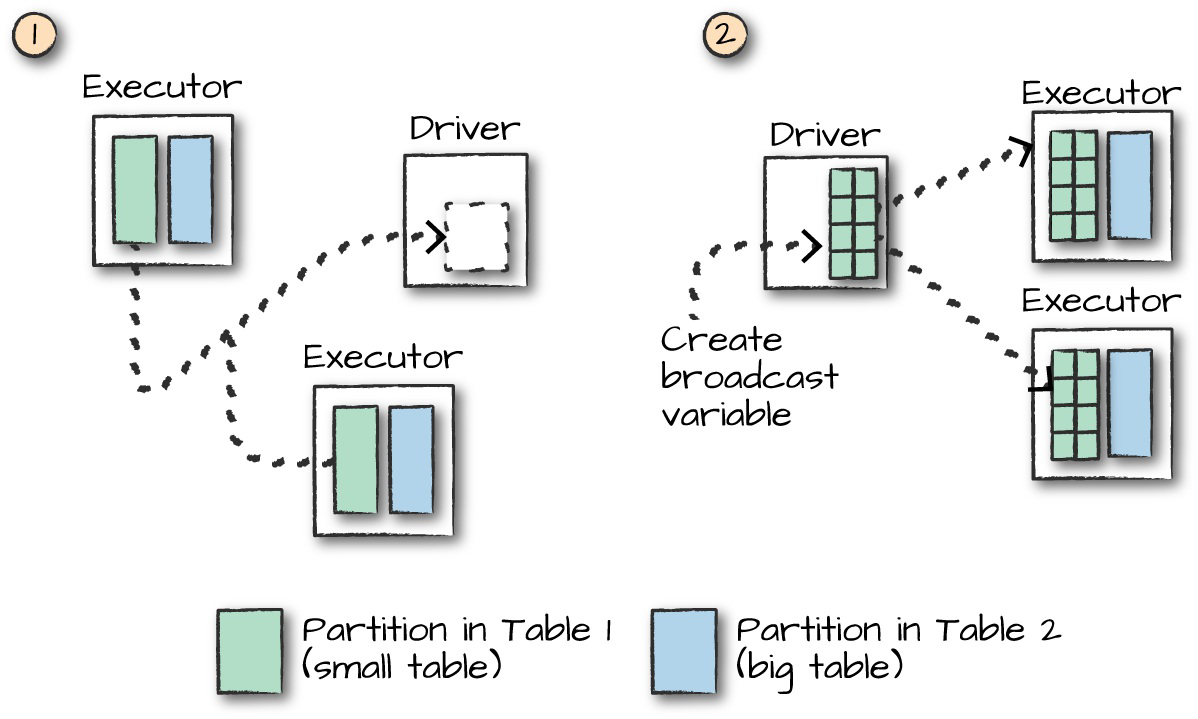


<!-- 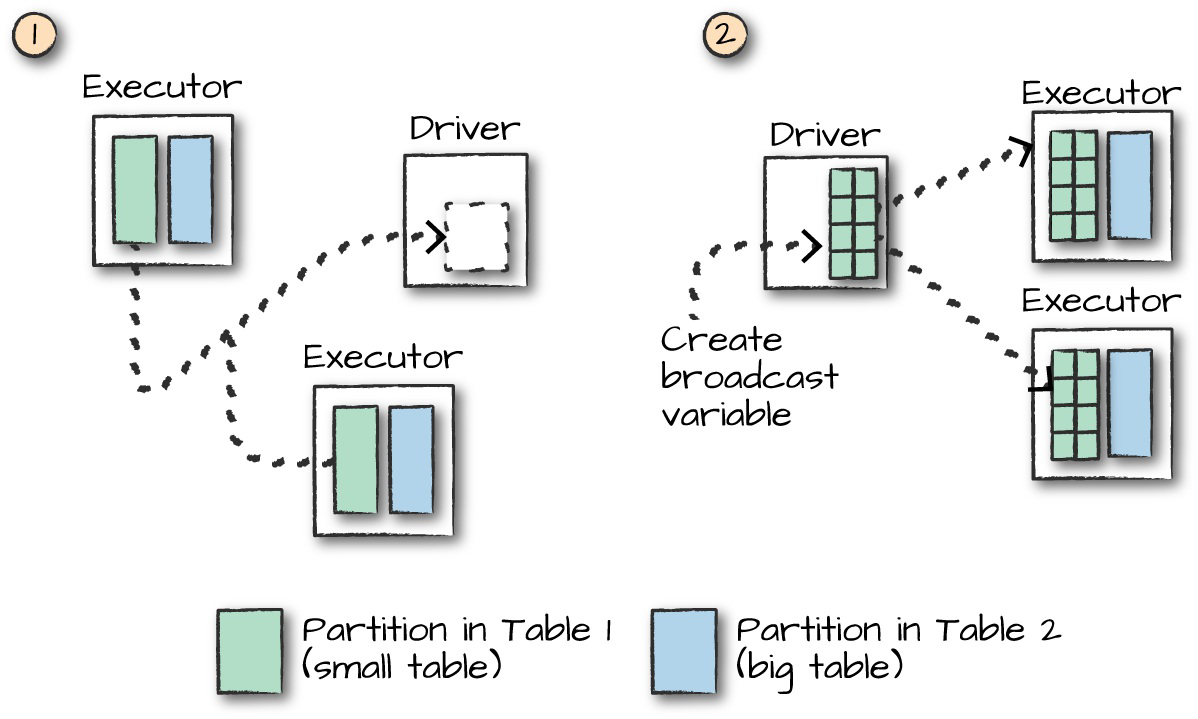 -->


In [47]:
person.join(graduateProgram, joinExpression).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [graduate_program#10L], [id#41L], Inner, BuildRight, false
   :- Filter isnotnull(graduate_program#10L)
   :  +- InMemoryTableScan [id#8L, name#9, graduate_program#10L, spark_status#11], [isnotnull(graduate_program#10L)]
   :        +- InMemoryRelation [id#8L, name#9, graduate_program#10L, spark_status#11], StorageLevel(disk, memory, deserialized, 1 replicas)
   :              +- *(1) Project [_1#0L AS id#8L, _2#1 AS name#9, _3#2L AS graduate_program#10L, _4#3 AS spark_status#11]
   :                 +- *(1) Scan ExistingRDD[_1#0L,_2#1,_3#2L,_4#3]
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, bigint, false]),false), [plan_id=1637]
      +- Filter isnotnull(id#41L)
         +- InMemoryTableScan [id#41L, degree#42, department#43, school#44], [isnotnull(id#41L)]
               +- InMemoryRelation [id#41L, degree#42, department#43, school#44], StorageLevel(disk, memory, deserialized, 1 replicas

In [48]:
# give the optimizer a hint that we would like to use a broadcast join.
# This doesn’t come for free either: if you try to broadcast something too large, you can crash your
# driver node (because that collect is expensive).
person.join(fn.broadcast(graduateProgram), joinExpression).explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [graduate_program#10L], [id#41L], Inner, BuildRight, false
   :- Filter isnotnull(graduate_program#10L)
   :  +- InMemoryTableScan [id#8L, name#9, graduate_program#10L, spark_status#11], [isnotnull(graduate_program#10L)]
   :        +- InMemoryRelation [id#8L, name#9, graduate_program#10L, spark_status#11], StorageLevel(disk, memory, deserialized, 1 replicas)
   :              +- *(1) Project [_1#0L AS id#8L, _2#1 AS name#9, _3#2L AS graduate_program#10L, _4#3 AS spark_status#11]
   :                 +- *(1) Scan ExistingRDD[_1#0L,_2#1,_3#2L,_4#3]
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, bigint, false]),false), [plan_id=1661]
      +- Filter isnotnull(id#41L)
         +- InMemoryTableScan [id#41L, degree#42, department#43, school#44], [isnotnull(id#41L)]
               +- InMemoryRelation [id#41L, degree#42, department#43, school#44], StorageLevel(disk, memory, deserialized, 1 replicas

In [ ]:
# Little table–to–little table
# When performing joins with small tables, it’s usually best to let Spark decide how to join them.
# You can always force a broadcast join if you’re noticing strange behavior.

<h3>Conclusion</h3>
<ul>
    <li>
        If you partition your data correctly prior to a join,</br>
        you can end up with much more efficient execution because even if a shuffle is planned, if data</br>
        from two different DataFrames is already located on the same machine, Spark can avoid the</br>
        shuffle.</br>
    </li>
</ul>

In [33]:
spark.stop()